In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, ConfusionMatrixDisplay

from additional import DataProcessor

In [46]:
def print_metric(values_true, values_pred, title):
    print(f'{title}:\n'
        f'{"":>4}F1: {f1_score(values_true, values_pred)}\n'
        f'{"":>4}precision: {precision_score(values_true, values_pred)}\n'
        f'{"":>4}recall: {recall_score(values_true, values_pred)}\n')

In [47]:
# load & prepare users info
user_features = pd.read_csv('hh_demographic.csv')
user_features.columns = user_features.columns.str.lower()
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [48]:
data = user_features.copy()

col_names = {
    'age_desc': 'age',
    'marital_status_code': 'marital',
    'income_desc': 'income',
    'homeowner_desc': 'homeowner',
    # 'hh_comp_desc': 'hh_comp',
    # 'household_size_desc': 'hh_size',
    # 'kid_category_desc': 'kids'
}
data.rename(columns=col_names, inplace=True)

In [49]:
# парсим данные о составе семьи - выделим необходимое в отдельные фичи и распарсим
data['hh_single'] = data['hh_comp_desc'].str.match(r'Single') * 1
data['hh_comp'] = data['hh_comp_desc'].str.replace(r'Single', '1', regex=True)   # меняем Single на число, чтоб адекватно распарсить
data['hh_comp'] = data['hh_comp'].str.extract(r'(\d+)').fillna(-1).astype('int')
data['hh_size'] = data['household_size_desc'].str.extract(r'(\d+)').fillna(-1).astype('int')    # hh_size есть у всех, в fillna() нет смысла
data['kids'] = data['kid_category_desc'].str.extract(r'(\d+)').fillna(-1).astype('int')

comp = data['hh_comp'] == -1
kids = data['kids'] == -1

In [50]:
# восстановим kids для тех, у кого он не указан, но указан comp, и обновим фильтр
data.loc[~comp & kids, 'kids'] = data.loc[~comp & kids, 'hh_size'] - data.loc[~comp & kids, 'hh_comp']
kids = data['kids'] == -1

# восстановим hh_comp для тех, у кого он не указан, но указан kids, и обновим фильтр
data.loc[comp & ~kids, 'hh_comp'] = data.loc[comp & ~kids, 'hh_size'] - data.loc[comp & ~kids, 'kids']
comp = data['hh_comp'] == -1

# те, у кого не указан hh_comp и kids, но hh_size = 1: скорее всего это single adult
size = data['hh_size'] == 1
data.loc[comp & kids & size, 'hh_comp'] = 1
data.loc[comp & kids & size, 'kids'] = 0

# обновим восстановленные данные в hh_single
single_mismatch = (data['hh_single'] == 0) & size
data.loc[single_mismatch, 'hh_single'] = 1

# обновим фильтры
broken = (data['hh_comp'] == -1) & (data['kids'] == -1)
data[broken]

,age,marital,income,homeowner,hh_comp_desc,household_size_desc,kid_category_desc,user_id,hh_single,hh_comp,hh_size,kids
140,25-34,A,25-34K,Unknown,Unknown,2,None/Unknown,404,0,-1,2,-1
218,55-64,A,50-74K,Homeowner,Unknown,2,None/Unknown,660,0,-1,2,-1
382,45-54,A,35-49K,Homeowner,Unknown,2,None/Unknown,1154,0,-1,2,-1


In [51]:
single = data['hh_single'] == 1
kids = data['kids'] == -1
comp = data['hh_comp'] == -1
data[single]

,age,marital,income,homeowner,hh_comp_desc,household_size_desc,kid_category_desc,user_id,hh_single,hh_comp,hh_size,kids
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16,1,1,1,0
7,35-44,B,15-24K,Unknown,Single Female,1,None/Unknown,19,1,1,1,0
10,35-44,U,50-74K,Unknown,Unknown,1,None/Unknown,25,1,1,1,0
11,45-54,U,25-34K,Probable Renter,Single Female,1,None/Unknown,27,1,1,1,0
15,65+,U,50-74K,Unknown,Single Male,1,None/Unknown,42,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
789,65+,A,15-24K,Homeowner,Single Female,2,None/Unknown,2465,1,1,2,1
792,45-54,B,75-99K,Homeowner,Single Male,1,None/Unknown,2483,1,1,1,0
793,35-44,B,25-34K,Unknown,Single Male,1,None/Unknown,2486,1,1,1,0
794,45-54,B,35-49K,Homeowner,Single Female,1,None/Unknown,2488,1,1,1,0


In [52]:
# теперь запилим признак пола для одиночных семей
# сначала инициализируем его в -1
data['single_female'] = -1

In [53]:
# теперь разметим: male = 0, female = 1
male = data['hh_comp_desc'].str.contains(r'Male')
female = data['hh_comp_desc'].str.contains(r'Female')
data.loc[male, 'single_female'] = 0
data.loc[female, 'single_female'] = 1
# отфильтруем одиночные семьи, для которых этот признак остался неразмеченным
sex = data['single_female'] == -1

# удалим распарсенные признаки
data.drop(columns=['hh_comp_desc', 'household_size_desc', 'kid_category_desc'], inplace=True)
# data[sex & single]

Для восстановления Male/Female соберем данные train/test:
Сюда попадут только single-family. Для train отберем размеченные, для test - неразмеченные.
Так же помним про троих non-single, которым надо восстановить hh_comp и kids.

In [54]:
# для восстановления Male/Female соберем данные в отдельные датасеты
sex_whole = data[~sex & single].drop(columns=['single_female']).copy()
sex_target = data.loc[~sex & single, 'single_female'].copy()
sex_test = data[sex & single].drop(columns=['single_female']).copy()

# отделим кусочек на валидацию
sex_train, sex_valid, sex_train_true, sex_valid_true = train_test_split(sex_whole, sex_target, test_size=0.25, random_state=13)


In [55]:
class Merger(BaseEstimator, TransformerMixin):
    """ Добавление данных о топе покупок """
    def __init__(self, k=10):
        self.k = k
        self.purchases = None

    def fit(self, X, y=None):
        dp = DataProcessor(pd.read_csv('retail_train.csv'), top_config={'k': self.k}, uim_config={'aggfunc': 'count'})
        dp.fit()
        self.purchases = ((dp.train_uim > 0) * 1).drop(columns=[0]).astype('int')
        self.purchases.columns = self.purchases.columns.astype('str')        
        return self
    
    def transform(self, X):
        return X.merge(self.purchases, on='user_id', how='left')

In [56]:
class Dummies(BaseEstimator, TransformerMixin):
    """ Добавление dummies из указанных фичей """
    def __init__(self, dumcol):
        self.dumcol = dumcol

    def fit(self, X, y=None):
        self.dumcol = [col for col in self.dumcol if col in X.columns]
        return self
    
    def transform(self, X):
        dum = pd.get_dummies(X[self.dumcol].astype('str'))
        df = pd.concat([X, dum], axis=1)
        return df

In [57]:
class ColumnsCorrector(BaseEstimator, TransformerMixin):
    """ Выброс фичей """
    def __init__(self, dropcol):
        self.dropcol = dropcol
        self.required_order = None

    def fit(self, X, y=None):
        self.dropcol = [col for col in self.dropcol if col in X.columns]
        self.required_order = [col for col in X.columns if col not in self.dropcol]
        return self
    
    def transform(self, X):
        df = X.copy()
        absence = list(set(X.columns) ^ set(self.required_order))
        df[absence] = 0
        df.drop(columns=self.dropcol, inplace=True)
        return df[self.required_order]

Train:
    F1: 0.7697594501718213
    precision: 0.6256983240223464
    recall: 1.0

Final metrics:
    F1: 0.7368421052631579
    precision: 0.6363636363636364
    recall: 0.875



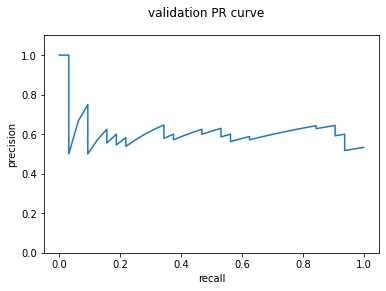

In [58]:
prepare = Pipeline([('merger', Merger(k=200)),
                    ('dummies', Dummies(['age', 'marital', 'income'])),
                    ('colcorrect', ColumnsCorrector(dropcol=['age', 'marital', 'income', 'homeowner', 'user_id'])),
                    ('classifier', SGDClassifier(early_stopping=True,
                                                 validation_fraction=0.5,
                                                 max_iter=100,
                                                #  alpha=0.01,
                                                 loss='log',
                                                 learning_rate='adaptive',
                                                 eta0=5e-4,
                                                 n_jobs=-1, random_state=2022))
                    ])

# обучаем моделечку
prepare.fit(sex_train, sex_train_true)

# считаем первое приближение метрик
print_metric(sex_train_true, prepare.predict(sex_train), 'Train')

# valivadion PR curve
beta = 1
valid_proba = prepare.predict_proba(sex_valid).T[1]
pr, rec, thr = precision_recall_curve(sex_valid_true, valid_proba)
f_beta = (1 + beta ** 2) * pr * rec / (beta ** 2 * pr + rec)
idx = f_beta.argmax()
threshold = thr[idx]
plt.suptitle('validation PR curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.ylim((0, 1.1))
plt.plot(rec, pr)

# итоговая метрика
# valid_proba = prepare.predict_proba(sex_valid).T[1]
valid_pred = (valid_proba > threshold) * 1
print_metric(sex_valid_true, valid_pred, 'Final metrics')

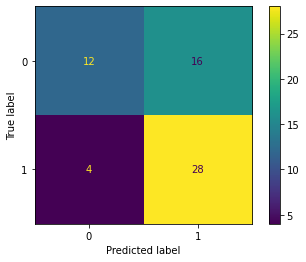

In [59]:
ConfusionMatrixDisplay.from_predictions(sex_valid_true, valid_pred);

Результат: модель определяет практически всех single женщин, но часто ошибочно называет single мужчин женщинами.
Учитывая, что данных для обучения очень мало, результат считаю приемлемым.

In [60]:
# заполняем исходные пропуски предиктами
test_pred = (prepare.predict_proba(sex_test) > threshold) * 1
data.loc[sex & single, 'single_female'] = test_pred.T[1]

# разбиваем на dummies
male = data['single_female'] == 0
data['single_male'] = 0
data.loc[male, 'single_male'] = 1
non_single = data['single_female'] == -1
data.loc[non_single, 'single_female'] = 0

In [61]:
# этот признак тоже можно попробовать починить, если будет время
data['homeowner'].value_counts()

Homeowner          504
Unknown            233
Renter              42
Probable Renter     11
Probable Owner      11
Name: homeowner, dtype: int64

In [62]:
# сразу подготовим данные для дальнейшего использования
# поскольку все переделываем в dummies, hh_single и hh_comp больше не нужны - они продублируются hh_size_1 и kids
# final_pipe = Pipeline([('dummies', Dummies(['age', 'marital', 'income', 'homeowner', 'hh_size', 'kids'])),
#                        ('colcorrect', ColumnsCorrector(dropcol=['age', 'marital', 'income', 'homeowner', 'hh_comp', 'hh_size', 'kids']))])

# final_pipe.fit(data)
# prepared = final_pipe.transform(data)

In [63]:
# подготовка - вариант 2
final_pipe = Pipeline([('dummies', Dummies(['age', 'marital', 'income'])),
                       ('colcorrect', ColumnsCorrector(dropcol=['age', 'marital', 'income', 'homeowner', 'hh_single']))])

final_pipe.fit(data)
prepared = final_pipe.transform(data)

In [64]:
# сохраняем результат
prepared.to_csv('user_features_corrected.csv', index=False)

# final overview
prepared

,user_id,hh_comp,hh_size,kids,single_female,single_male,age_19-24,age_25-34,age_35-44,age_45-54,...,income_15-24K,income_150-174K,income_175-199K,income_200-249K,income_25-34K,income_250K+,income_35-49K,income_50-74K,income_75-99K,income_Under 15K
0,1,2,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,7,2,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,8,2,3,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,13,2,4,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,16,1,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,2494,2,2,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
797,2496,2,3,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
798,2497,1,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
799,2498,2,2,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


Что НЕ сделано:
1) не обработаны те трое, с неуказанными hh_comp и kids: пока непонятно, как выяснить, это 2 взрослых или single + kid
2) никак не обрабатываются Unknown в homeowner: их примерно треть от всех данных и очень большой дисбаланс между размеченными классами

In [65]:
data[data['kids'] == -1]

,age,marital,income,homeowner,user_id,hh_single,hh_comp,hh_size,kids,single_female,single_male
140,25-34,A,25-34K,Unknown,404,0,-1,2,-1,0,0
218,55-64,A,50-74K,Homeowner,660,0,-1,2,-1,0,0
382,45-54,A,35-49K,Homeowner,1154,0,-1,2,-1,0,0
